In [157]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_undistort_pts():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('camera_cal/calibration*.jpg')
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints



In [158]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

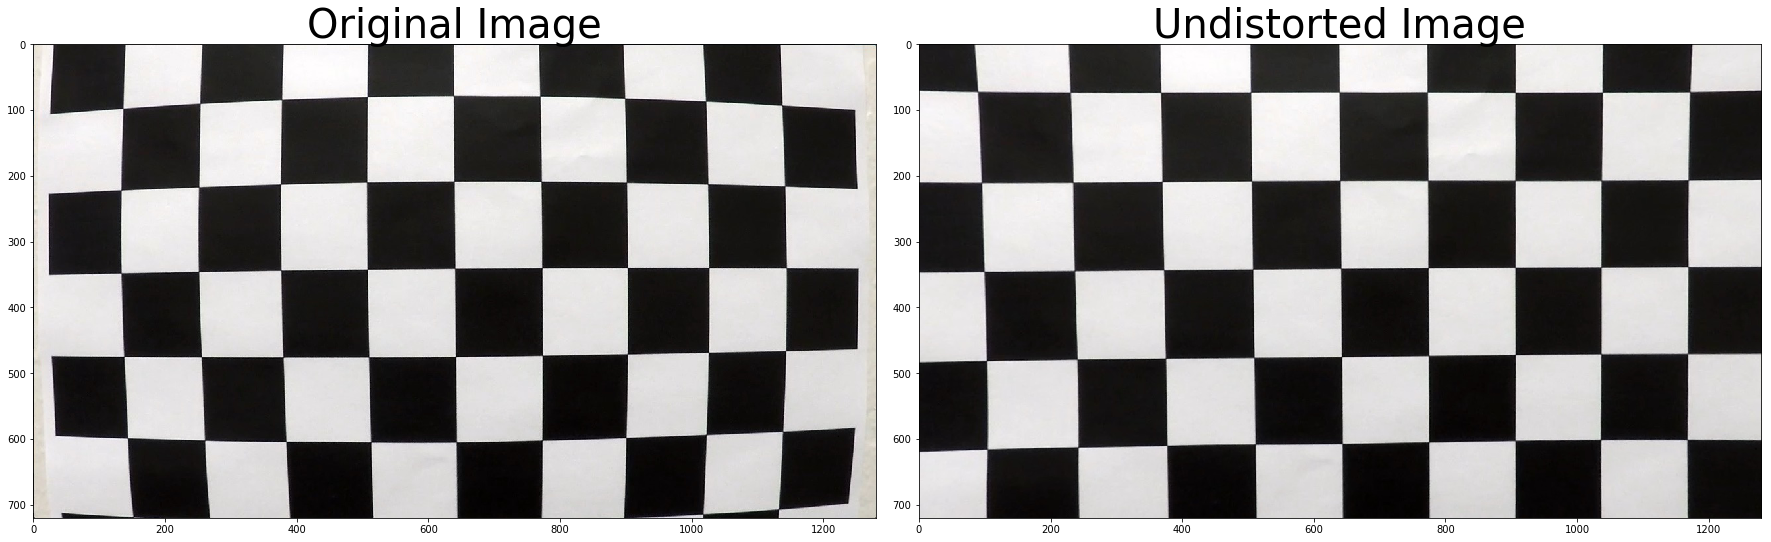

In [164]:
img = mpimg.imread('camera_cal/calibration1.jpg')
objpoints, imgpoints = get_undistort_pts()
undist = cal_undistort(img, objpoints, imgpoints)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistort.jpg')

In [24]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [25]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold x gradient
    s_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    return s_binary


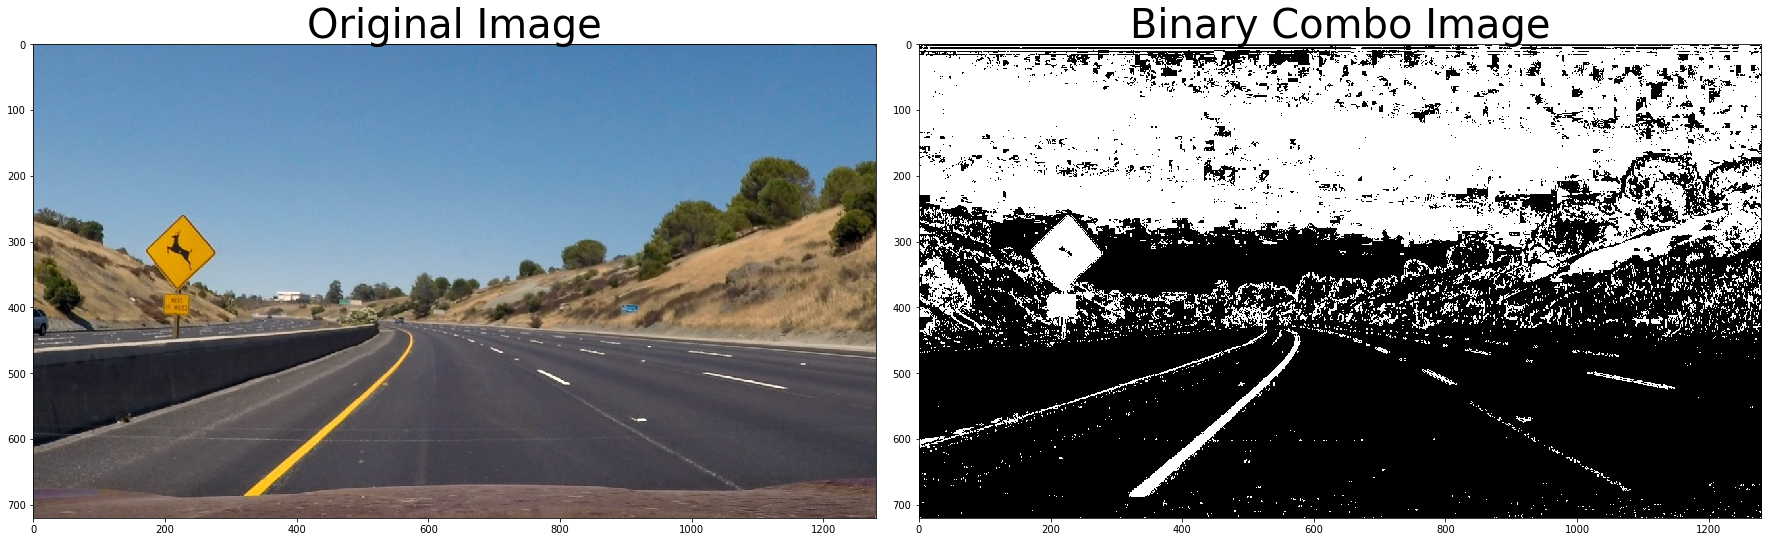

In [163]:
img = mpimg.imread('test_images/test2.jpg')
binary = pipeline(img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Combo Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/binary_combo.jpg')

In [186]:
def unwarp(img, src):
    img_size = (img.shape[1], img.shape[0])
    
    offset = 30
    
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    #dst = np.float32([[0,h], [w,h], [w,0], [0,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, Minv

In [187]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return ploty, left_fitx, right_fitx, left_fit, right_fit

In [188]:

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [189]:
def avg(lst):
    return sum(lst)/len(lst)

def pos(num):
    if num > 0:
        return True
    
    return False

In [190]:
def measure_curvature_and_position(img_shape, ploty, left_fit_cr, right_fit_cr, left_x, right_x):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    center = np.mean([left_x, right_x]) + 210

    curvature = np.mean([left_curverad, right_curverad])
    position = (center - img_shape[1]/2) * xm_per_pix
        
    return curvature, position

In [191]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return ploty, left_fitx, right_fitx

In [192]:
def sanity_check(img_shape, prev_lines, ploty, left_poly, right_poly, left_fitx, right_fitx):
    horiz_dist = avg(right_fitx) - avg(left_fitx)
    
    if horiz_dist < 600 or horiz_dist > 1000:
        return False
    
    if pos(left_poly[0]) and not pos(right_poly[0]):
        return False
    
    if not pos(left_poly[0]) and pos(right_poly[0]):
        return False
    
    if pos(left_poly[1]) and not pos(right_poly[1]):
        return False
    
    if not pos(left_poly[1]) and pos(right_poly[1]):
        return False
        
    
    return True
    

In [193]:
def find_lanes(test_img, prev_lines):
    objpoints, imgpoints = get_undistort_pts()
    undist = cal_undistort(test_img, objpoints, imgpoints)
    edges = pipeline(undist)

    h,w,_ = test_img.shape
    img_size = (test_img.shape[1], test_img.shape[0])

    src3 = np.array([[(w//2+60,h//2+80), (w//2-60,h//2+80), (0,h), (w,h)]])
    src2 = np.float32([[(w//2+60,h//2+80), (w//2-60, h//2+80), (0,h), (w,h)]])
    masked = region_of_interest(edges, src3)

    warped, Minv = unwarp(masked, src2)
    
    #plt.imsave('output_images/masked.jpg', masked)
    #plt.imsave('output_images/warped.jpg', warped)
    
    if prev_lines:
        left_fit = prev_lines[-1][0].best_fit
        right_fit = prev_lines[-1][1].best_fit
        ploty, left_fitx, right_fitx = search_around_poly(warped, left_fit, right_fit)
        
        if not sanity_check(test_img.shape, prev_lines, ploty, left_fit, right_fit, left_fitx, right_fitx):
            print("NOT SANE")
            ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomial(warped)
        
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomial(warped)
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    curvature, position = measure_curvature_and_position(test_img.shape, ploty, left_fit, right_fit, pts_left, pts_right)
    if position == 0:
        pos_text = "Vehicle is in the center"
    elif position > 0:
        pos_text = "Vehicle is " + str(round(position,2)) + "m right of center"
    else:
        pos_text = "Vehicle is " + str(round(position,2)) + "m left of center"
    
    cv2.putText(result,"Radius of Curvature = {}m".format(abs(round(curvature,2))),(100,100),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 3)
    cv2.putText(result,pos_text,(100,130),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 3)
    
    return result, left_fitx, right_fitx, left_fit, right_fit, curvature


In [194]:
prev_lines = []
def process_image(image):
    global prev_lines
    if len(prev_lines) == 1:
        prev_lines = []
    
    result, left_fitx, right_fitx, left_fit, right_fit, curvature = find_lanes(image, prev_lines)
    
    l_line = Line()
    r_line = Line()
    l_line.best_fit = left_fit
    r_line.best_fit = right_fit
    l_line.radius_of_curvature = curvature
    r_line.radius_of_curvature = curvature
    
    prev_lines.append((l_line, r_line))
    
    return result

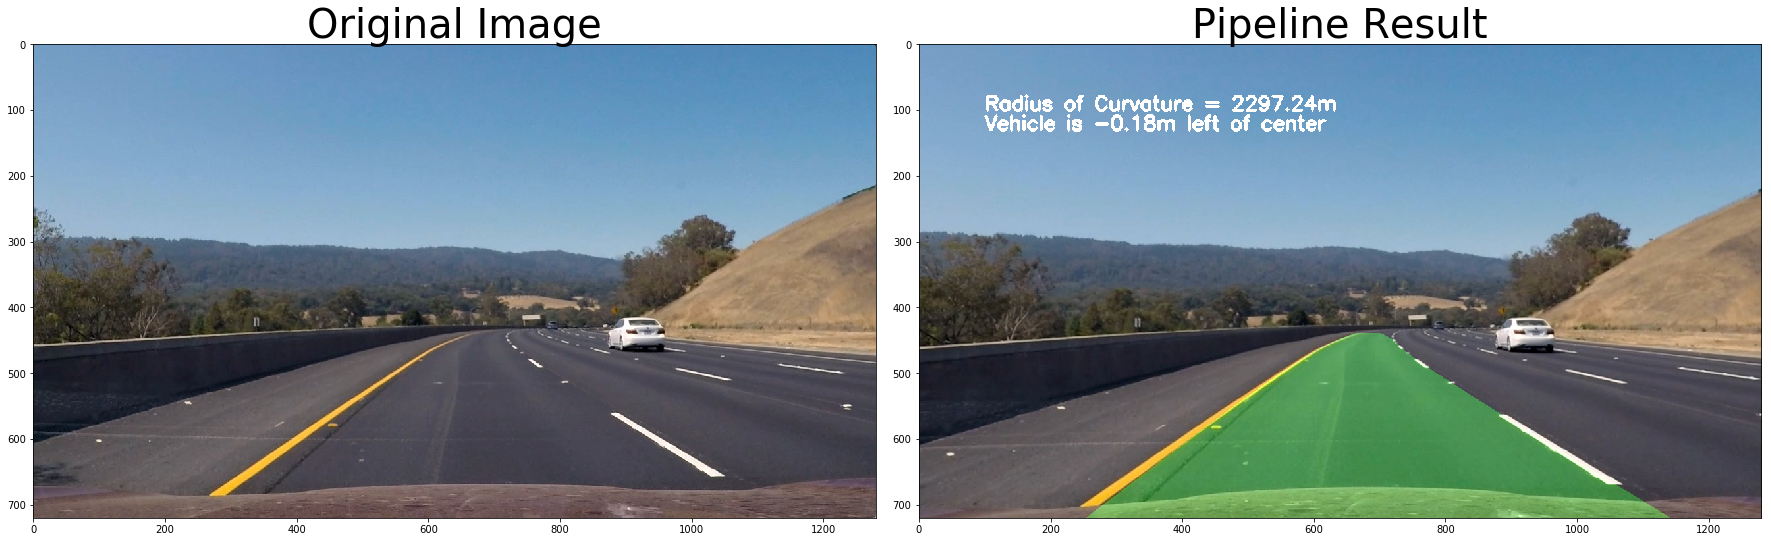

In [196]:

test_img = mpimg.imread('test_images/test3.jpg')

result = process_image(test_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/video_output.jpg')

In [150]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(output, audio=False)


                                                               


                                                   
                                                                

t:   7%|▋         | 7/100 [22:27:02<05:33,  3.59s/it, now=None]   


t:   1%|          | 12/1260 [22:12:21<1:22:58,  3.99s/it, now=None]

                                                               ne]


                                                   
                                                                

t:   7%|▋         | 7/100 [22:27:02<05:33,  3.59s/it, now=None]   


t:   1%|          | 12/1260 [22:12:21<1:22:58,  3.99s/it, now=None]

t:   1%|▏         | 18/1260 [6:25:01<1:29:15,  4.31s/it, now=None]



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4







t:   0%|          | 2/1260 [00:04<44:04,  2.10s/it, now=None]



t:   0%|          | 3/1260 [00:08<59:12,  2.83s/it, now=None]



t:   0%|          | 4/1260 [00:12<1:05:30,  3.13s/it, now=None]



t:   0%|          | 5/1260 [00:16<1:08:46,  3.29s/it, now=None]



t:   0%|          | 6/1260 [00:20<1:16:54,  3.68s/it, now=None]



t:   1%|          | 7/1260 [00:24<1:19:58,  3.83s/it, now=None]



t:   1%|          | 8/1260 [00:29<1:22:29,  3.95s/it, now=None]



t:   1%|          | 9/1260 [00:33<1:23:41,  4.01s/it, now=None]



t:   1%|          | 10/1260 [00:37<1:22:17,  3.95s/it, now=None]



t:   1%|          | 11/1260 [00:40<1:21:07,  3.90s/it, now=None]



t:   1%|          | 12/1260 [00:44<1:18:58,  3.80s/it, now=None]



t:   1%|          | 13/1260 [00:48<1:17:17,  3.72s/it, now=None]



t:   1%|          | 14/1260 [00:52<1:19:13,  3.81s/it, now=None]



t:   1%|          | 15/1260 [00:55<1:17:38,  3.74s/it, now=None]



t:   1%|▏         | 16/1260 [00:59<1:17:58,  3.76s/it, n

t:   8%|▊         | 104/1260 [07:09<1:23:22,  4.33s/it, now=None]



t:   8%|▊         | 105/1260 [07:14<1:23:53,  4.36s/it, now=None]



t:   8%|▊         | 106/1260 [07:18<1:22:28,  4.29s/it, now=None]



t:   8%|▊         | 107/1260 [07:22<1:21:27,  4.24s/it, now=None]



t:   9%|▊         | 108/1260 [07:26<1:20:40,  4.20s/it, now=None]



t:   9%|▊         | 109/1260 [07:30<1:20:11,  4.18s/it, now=None]



t:   9%|▊         | 110/1260 [07:34<1:19:38,  4.16s/it, now=None]



t:   9%|▉         | 111/1260 [07:39<1:19:31,  4.15s/it, now=None]



t:   9%|▉         | 112/1260 [07:43<1:19:14,  4.14s/it, now=None]



t:   9%|▉         | 113/1260 [07:47<1:19:35,  4.16s/it, now=None]



t:   9%|▉         | 114/1260 [07:51<1:19:16,  4.15s/it, now=None]



t:   9%|▉         | 115/1260 [07:55<1:19:41,  4.18s/it, now=None]



t:   9%|▉         | 116/1260 [08:01<1:29:27,  4.69s/it, now=None]



t:   9%|▉         | 117/1260 [08:06<1:29:01,  4.67s/it, now=None]



t:   9%|▉         | 118/1260 [08:0

t:  16%|█▋        | 205/1260 [13:50<1:04:29,  3.67s/it, now=None]



t:  16%|█▋        | 206/1260 [13:54<1:04:24,  3.67s/it, now=None]



t:  16%|█▋        | 207/1260 [13:58<1:04:28,  3.67s/it, now=None]



t:  17%|█▋        | 208/1260 [14:01<1:04:18,  3.67s/it, now=None]



t:  17%|█▋        | 209/1260 [14:05<1:04:57,  3.71s/it, now=None]



t:  17%|█▋        | 210/1260 [14:09<1:04:41,  3.70s/it, now=None]



t:  17%|█▋        | 211/1260 [14:13<1:04:33,  3.69s/it, now=None]



t:  17%|█▋        | 212/1260 [14:16<1:04:20,  3.68s/it, now=None]



t:  17%|█▋        | 213/1260 [14:20<1:04:09,  3.68s/it, now=None]



t:  17%|█▋        | 214/1260 [14:24<1:04:10,  3.68s/it, now=None]



t:  17%|█▋        | 215/1260 [14:27<1:03:49,  3.66s/it, now=None]



t:  17%|█▋        | 216/1260 [14:31<1:03:51,  3.67s/it, now=None]



t:  17%|█▋        | 217/1260 [14:35<1:04:17,  3.70s/it, now=None]



t:  17%|█▋        | 218/1260 [14:38<1:04:12,  3.70s/it, now=None]



t:  17%|█▋        | 219/1260 [14:4

t:  24%|██▍       | 306/1260 [20:00<57:04,  3.59s/it, now=None]



t:  24%|██▍       | 307/1260 [20:03<57:06,  3.60s/it, now=None]



t:  24%|██▍       | 308/1260 [20:07<57:00,  3.59s/it, now=None]



t:  25%|██▍       | 309/1260 [20:11<56:56,  3.59s/it, now=None]



t:  25%|██▍       | 310/1260 [20:14<58:03,  3.67s/it, now=None]



t:  25%|██▍       | 311/1260 [20:19<1:02:22,  3.94s/it, now=None]



t:  25%|██▍       | 312/1260 [20:23<1:00:32,  3.83s/it, now=None]



t:  25%|██▍       | 313/1260 [20:26<59:10,  3.75s/it, now=None]  



t:  25%|██▍       | 314/1260 [20:30<58:19,  3.70s/it, now=None]



t:  25%|██▌       | 315/1260 [20:33<57:43,  3.67s/it, now=None]



t:  25%|██▌       | 316/1260 [20:37<57:13,  3.64s/it, now=None]



t:  25%|██▌       | 317/1260 [20:41<56:49,  3.62s/it, now=None]



t:  25%|██▌       | 318/1260 [20:44<56:34,  3.60s/it, now=None]



t:  25%|██▌       | 319/1260 [20:48<56:42,  3.62s/it, now=None]



t:  25%|██▌       | 320/1260 [20:51<56:43,  3.62s/it, no

t:  32%|███▏      | 409/1260 [26:16<51:27,  3.63s/it, now=None]



t:  33%|███▎      | 410/1260 [26:20<51:21,  3.63s/it, now=None]



t:  33%|███▎      | 411/1260 [26:23<51:09,  3.61s/it, now=None]



t:  33%|███▎      | 412/1260 [26:27<50:57,  3.61s/it, now=None]



t:  33%|███▎      | 413/1260 [26:30<50:45,  3.60s/it, now=None]



t:  33%|███▎      | 414/1260 [26:34<50:33,  3.59s/it, now=None]



t:  33%|███▎      | 415/1260 [26:38<50:32,  3.59s/it, now=None]



t:  33%|███▎      | 416/1260 [26:41<50:24,  3.58s/it, now=None]



t:  33%|███▎      | 417/1260 [26:45<50:24,  3.59s/it, now=None]



t:  33%|███▎      | 418/1260 [26:48<50:15,  3.58s/it, now=None]



t:  33%|███▎      | 419/1260 [26:52<50:17,  3.59s/it, now=None]



t:  33%|███▎      | 420/1260 [26:55<50:13,  3.59s/it, now=None]



t:  33%|███▎      | 421/1260 [26:59<50:02,  3.58s/it, now=None]



t:  33%|███▎      | 422/1260 [27:03<50:02,  3.58s/it, now=None]



t:  34%|███▎      | 423/1260 [27:06<49:56,  3.58s/it, now=None

t:  41%|████      | 512/1260 [32:28<44:54,  3.60s/it, now=None]



t:  41%|████      | 513/1260 [32:31<44:52,  3.60s/it, now=None]



t:  41%|████      | 514/1260 [32:35<44:42,  3.60s/it, now=None]



t:  41%|████      | 515/1260 [32:39<44:35,  3.59s/it, now=None]



t:  41%|████      | 516/1260 [32:42<44:28,  3.59s/it, now=None]



t:  41%|████      | 517/1260 [32:46<44:20,  3.58s/it, now=None]



t:  41%|████      | 518/1260 [32:49<44:16,  3.58s/it, now=None]



t:  41%|████      | 519/1260 [32:53<44:08,  3.57s/it, now=None]



t:  41%|████▏     | 520/1260 [32:56<44:02,  3.57s/it, now=None]



t:  41%|████▏     | 521/1260 [33:00<44:01,  3.57s/it, now=None]



t:  41%|████▏     | 522/1260 [33:04<43:54,  3.57s/it, now=None]



t:  42%|████▏     | 523/1260 [33:07<43:46,  3.56s/it, now=None]



t:  42%|████▏     | 524/1260 [33:11<43:40,  3.56s/it, now=None]



t:  42%|████▏     | 525/1260 [33:14<44:14,  3.61s/it, now=None]



t:  42%|████▏     | 526/1260 [33:18<44:03,  3.60s/it, now=None

t:  49%|████▉     | 615/1260 [38:36<38:13,  3.56s/it, now=None]



t:  49%|████▉     | 616/1260 [38:40<38:10,  3.56s/it, now=None]



t:  49%|████▉     | 617/1260 [38:43<38:14,  3.57s/it, now=None]



t:  49%|████▉     | 618/1260 [38:47<38:11,  3.57s/it, now=None]



t:  49%|████▉     | 619/1260 [38:50<38:05,  3.56s/it, now=None]



t:  49%|████▉     | 620/1260 [38:54<37:58,  3.56s/it, now=None]



t:  49%|████▉     | 621/1260 [38:59<42:15,  3.97s/it, now=None]



t:  49%|████▉     | 622/1260 [39:02<40:55,  3.85s/it, now=None]



t:  49%|████▉     | 623/1260 [39:06<40:43,  3.84s/it, now=None]



t:  50%|████▉     | 624/1260 [39:10<39:50,  3.76s/it, now=None]



t:  50%|████▉     | 625/1260 [39:13<39:52,  3.77s/it, now=None]



t:  50%|████▉     | 626/1260 [39:17<39:25,  3.73s/it, now=None]



t:  50%|████▉     | 627/1260 [39:21<38:58,  3.69s/it, now=None]



t:  50%|████▉     | 628/1260 [39:24<38:38,  3.67s/it, now=None]



t:  50%|████▉     | 629/1260 [39:28<38:15,  3.64s/it, now=None

t:  57%|█████▋    | 718/1260 [44:47<32:16,  3.57s/it, now=None]



t:  57%|█████▋    | 719/1260 [44:50<32:12,  3.57s/it, now=None]



t:  57%|█████▋    | 720/1260 [44:54<32:01,  3.56s/it, now=None]



t:  57%|█████▋    | 721/1260 [44:57<31:58,  3.56s/it, now=None]



t:  57%|█████▋    | 722/1260 [45:01<31:51,  3.55s/it, now=None]



t:  57%|█████▋    | 723/1260 [45:04<31:44,  3.55s/it, now=None]



t:  57%|█████▋    | 724/1260 [45:08<31:40,  3.55s/it, now=None]



t:  58%|█████▊    | 725/1260 [45:12<31:39,  3.55s/it, now=None]



t:  58%|█████▊    | 726/1260 [45:15<32:10,  3.62s/it, now=None]



t:  58%|█████▊    | 727/1260 [45:19<32:41,  3.68s/it, now=None]



t:  58%|█████▊    | 728/1260 [45:23<32:40,  3.69s/it, now=None]



t:  58%|█████▊    | 729/1260 [45:26<32:19,  3.65s/it, now=None]



t:  58%|█████▊    | 730/1260 [45:30<32:01,  3.63s/it, now=None]



t:  58%|█████▊    | 731/1260 [45:34<31:44,  3.60s/it, now=None]



t:  58%|█████▊    | 732/1260 [45:37<31:32,  3.58s/it, now=None

t:  65%|██████▌   | 821/1260 [50:58<26:05,  3.57s/it, now=None]



t:  65%|██████▌   | 822/1260 [51:01<25:57,  3.56s/it, now=None]



t:  65%|██████▌   | 823/1260 [51:05<25:58,  3.57s/it, now=None]



t:  65%|██████▌   | 824/1260 [51:09<26:04,  3.59s/it, now=None]



t:  65%|██████▌   | 825/1260 [51:12<26:21,  3.64s/it, now=None]



t:  66%|██████▌   | 826/1260 [51:16<26:40,  3.69s/it, now=None]



t:  66%|██████▌   | 827/1260 [51:20<27:10,  3.77s/it, now=None]



t:  66%|██████▌   | 828/1260 [51:24<27:28,  3.82s/it, now=None]



t:  66%|██████▌   | 829/1260 [51:28<27:41,  3.85s/it, now=None]



t:  66%|██████▌   | 830/1260 [51:32<29:00,  4.05s/it, now=None]



t:  66%|██████▌   | 831/1260 [51:36<28:32,  3.99s/it, now=None]



t:  66%|██████▌   | 832/1260 [51:40<27:30,  3.86s/it, now=None]



t:  66%|██████▌   | 833/1260 [51:43<26:51,  3.77s/it, now=None]



t:  66%|██████▌   | 834/1260 [51:47<26:20,  3.71s/it, now=None]



t:  66%|██████▋   | 835/1260 [51:51<26:01,  3.67s/it, now=None

t:  73%|███████▎  | 924/1260 [57:11<20:01,  3.58s/it, now=None]



t:  73%|███████▎  | 925/1260 [57:15<20:17,  3.63s/it, now=None]



t:  73%|███████▎  | 926/1260 [57:19<20:06,  3.61s/it, now=None]



t:  74%|███████▎  | 927/1260 [57:22<19:56,  3.59s/it, now=None]



t:  74%|███████▎  | 928/1260 [57:26<19:50,  3.59s/it, now=None]



t:  74%|███████▎  | 929/1260 [57:29<19:47,  3.59s/it, now=None]



t:  74%|███████▍  | 930/1260 [57:34<20:47,  3.78s/it, now=None]



t:  74%|███████▍  | 931/1260 [57:37<20:23,  3.72s/it, now=None]



t:  74%|███████▍  | 932/1260 [57:41<20:07,  3.68s/it, now=None]



t:  74%|███████▍  | 933/1260 [57:44<19:51,  3.64s/it, now=None]



t:  74%|███████▍  | 934/1260 [57:48<19:37,  3.61s/it, now=None]



t:  74%|███████▍  | 935/1260 [57:51<19:29,  3.60s/it, now=None]



t:  74%|███████▍  | 936/1260 [57:55<19:20,  3.58s/it, now=None]



t:  74%|███████▍  | 937/1260 [57:58<19:12,  3.57s/it, now=None]



t:  74%|███████▍  | 938/1260 [58:02<19:07,  3.56s/it, now=None

t:  81%|████████▏ | 1026/1260 [1:03:19<15:52,  4.07s/it, now=None]



t:  82%|████████▏ | 1027/1260 [1:03:23<15:28,  3.98s/it, now=None]



t:  82%|████████▏ | 1028/1260 [1:03:26<14:55,  3.86s/it, now=None]



t:  82%|████████▏ | 1029/1260 [1:03:30<14:29,  3.76s/it, now=None]



t:  82%|████████▏ | 1030/1260 [1:03:33<14:11,  3.70s/it, now=None]



t:  82%|████████▏ | 1031/1260 [1:03:37<13:57,  3.66s/it, now=None]



t:  82%|████████▏ | 1032/1260 [1:03:40<13:46,  3.62s/it, now=None]



t:  82%|████████▏ | 1033/1260 [1:03:44<13:37,  3.60s/it, now=None]



t:  82%|████████▏ | 1034/1260 [1:03:48<13:29,  3.58s/it, now=None]



t:  82%|████████▏ | 1035/1260 [1:03:51<13:25,  3.58s/it, now=None]



t:  82%|████████▏ | 1036/1260 [1:03:55<13:22,  3.58s/it, now=None]



t:  82%|████████▏ | 1037/1260 [1:03:58<13:17,  3.58s/it, now=None]



t:  82%|████████▏ | 1038/1260 [1:04:02<13:12,  3.57s/it, now=None]



t:  82%|████████▏ | 1039/1260 [1:04:05<13:13,  3.59s/it, now=None]



t:  83%|████████▎ | 

t:  89%|████████▉ | 1125/1260 [1:09:15<08:15,  3.67s/it, now=None]



t:  89%|████████▉ | 1126/1260 [1:09:18<08:23,  3.76s/it, now=None]



t:  89%|████████▉ | 1127/1260 [1:09:22<08:26,  3.80s/it, now=None]



t:  90%|████████▉ | 1128/1260 [1:09:26<08:13,  3.74s/it, now=None]



t:  90%|████████▉ | 1129/1260 [1:09:30<08:01,  3.68s/it, now=None]



t:  90%|████████▉ | 1130/1260 [1:09:33<07:53,  3.64s/it, now=None]



t:  90%|████████▉ | 1131/1260 [1:09:37<07:46,  3.62s/it, now=None]



t:  90%|████████▉ | 1132/1260 [1:09:40<07:42,  3.61s/it, now=None]



t:  90%|████████▉ | 1133/1260 [1:09:44<07:36,  3.59s/it, now=None]



t:  90%|█████████ | 1134/1260 [1:09:47<07:31,  3.58s/it, now=None]



t:  90%|█████████ | 1135/1260 [1:09:51<07:27,  3.58s/it, now=None]



t:  90%|█████████ | 1136/1260 [1:09:54<07:22,  3.57s/it, now=None]



t:  90%|█████████ | 1137/1260 [1:09:58<07:18,  3.57s/it, now=None]



t:  90%|█████████ | 1138/1260 [1:10:02<07:15,  3.57s/it, now=None]



t:  90%|█████████ | 

t:  97%|█████████▋| 1224/1260 [1:15:19<02:11,  3.65s/it, now=None]



t:  97%|█████████▋| 1225/1260 [1:15:22<02:07,  3.63s/it, now=None]



t:  97%|█████████▋| 1226/1260 [1:15:26<02:02,  3.61s/it, now=None]



t:  97%|█████████▋| 1227/1260 [1:15:29<01:58,  3.59s/it, now=None]



t:  97%|█████████▋| 1228/1260 [1:15:33<01:58,  3.69s/it, now=None]



t:  98%|█████████▊| 1229/1260 [1:15:38<02:02,  3.97s/it, now=None]



t:  98%|█████████▊| 1230/1260 [1:15:42<01:55,  3.85s/it, now=None]



t:  98%|█████████▊| 1231/1260 [1:15:45<01:48,  3.76s/it, now=None]



t:  98%|█████████▊| 1232/1260 [1:15:49<01:43,  3.71s/it, now=None]



t:  98%|█████████▊| 1233/1260 [1:15:52<01:38,  3.66s/it, now=None]



t:  98%|█████████▊| 1234/1260 [1:15:56<01:34,  3.63s/it, now=None]



t:  98%|█████████▊| 1235/1260 [1:15:59<01:30,  3.60s/it, now=None]



t:  98%|█████████▊| 1236/1260 [1:16:03<01:26,  3.59s/it, now=None]



t:  98%|█████████▊| 1237/1260 [1:16:07<01:23,  3.64s/it, now=None]



t:  98%|█████████▊| 

Moviepy - Done !
Moviepy - video ready project_video_output.mp4


In [151]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))